In [ ]:
# 1.Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning tools and models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.cluster import KMeans
import xgboost as xgb

# For time calculations
from datetime import timedelta

In [ ]:
# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

In [ ]:
# 2. Data Loading and Initial Exploration
# ------------------------
# Adjust the path to where your CSV is stored
retail = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
print("Initial data shape:", retail.shape)

# View the first few rows to understand the structure
print("\nFirst 5 rows:")
print(retail.head())

# Check data info
print("\nData Info:")
retail.info()

# Check for missing values
print("\nMissing values:")
print(retail.isnull().sum())

Initial data shape: (49912, 8)

First 5 rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49912 entries, 0 to 49911
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  

In [ ]:
# 3. Data Cleaning
# ------------------------
# Drop rows with missing CustomerID
retail = retail.dropna(subset=['CustomerID'])
print("\nData shape after dropping missing CustomerID:", retail.shape)




Data shape after dropping missing CustomerID: (32030, 8)


In [ ]:
# Keep only records with positive UnitPrice

# Remove rows with non-positive UnitPrice
retail = retail[retail['UnitPrice'] > 0]
print("Data shape after removing non-positive prices:", retail.shape)



Data shape after removing non-positive prices: (32025, 8)


In [ ]:
# Create a 'Cancelled' column: 1 if InvoiceNo starts with 'C', else 0
retail['Cancelled'] = retail['InvoiceNo'].apply(lambda x: 1 if str(x).startswith('C') else 0)



In [ ]:
# Check distribution of cancelled orders
print("\nCancellation distribution:")
print(retail['Cancelled'].value_counts())
print(f"Cancellation rate: {retail['Cancelled'].mean():.2%}")


Cancellation distribution:
Cancelled
0    31145
1      880
Name: count, dtype: int64
Cancellation rate: 2.75%


In [ ]:
# 4. Feature Engineering
# ------------------------
# Create new meaningful columns
retail['TotalPrice'] = retail['Quantity'] * retail['UnitPrice']
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail['Month'] = retail['InvoiceDate'].dt.month
retail['Hour'] = retail['InvoiceDate'].dt.hour
retail['DayOfWeek'] = retail['InvoiceDate'].dt.dayofweek
retail['IsWeekend'] = retail['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
retail['DayOfMonth'] = retail['InvoiceDate'].dt.day
retail['Quarter'] = retail['InvoiceDate'].dt.quarter
retail['YearMonth'] = retail['InvoiceDate'].dt.to_period('M')

In [ ]:
# 4B. Fix Class Imbalance (Downsampling Majority Class)
# ------------------------
# Split data into majority (non-cancelled) and minority (cancelled)
df_majority = retail[retail['Cancelled'] == 0]
df_minority = retail[retail['Cancelled'] == 1]

print("\nMinority class count (Cancelled=1):", len(df_minority))
print("Majority class count (Cancelled=0):", len(df_majority))


Minority class count (Cancelled=1): 880
Majority class count (Cancelled=0): 31145


In [ ]:
# Check if minority class exists, balance the dataset
if len(df_minority) > 0:
    # Downsample majority class
    df_majority_downsampled = resample(df_majority,
                                    replace=False,
                                    n_samples=len(df_minority)*5,
                                    random_state=42)

    # Combine minority class with downsampled majority class
    retail_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Shuffle the new dataset
    retail_balanced = retail_balanced.sample(frac=1, random_state=42)
    print(f"Balanced dataset shape: {retail_balanced.shape}")
else:
    print("❗ No Cancelled invoices found after cleaning. Please recheck data preparation!")
    retail_balanced = retail.copy()

Balanced dataset shape: (5280, 17)


In [ ]:
# 5. Time-Based Features Analysis
# ------------------------
# Sort data by CustomerID and InvoiceDate
retail_sorted = retail.sort_values(['CustomerID', 'InvoiceDate'])

# Calculate time between purchases for each customer
retail_sorted['PrevPurchaseDate'] = retail_sorted.groupby('CustomerID')['InvoiceDate'].shift(1)
retail_sorted['DaysSincePrevPurchase'] = (retail_sorted['InvoiceDate'] - retail_sorted['PrevPurchaseDate']).dt.total_seconds() / (24*60*60)

# Replace NaN values (first purchase) with a high value
retail_sorted['DaysSincePrevPurchase'].fillna(365, inplace=True)  # Assume 1 year for first purchase

<ipython-input-12-bc421bc39ce4>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  retail_sorted['DaysSincePrevPurchase'].fillna(365, inplace=True)  # Assume 1 year for first purchase



Starting Exploratory Data Analysis...


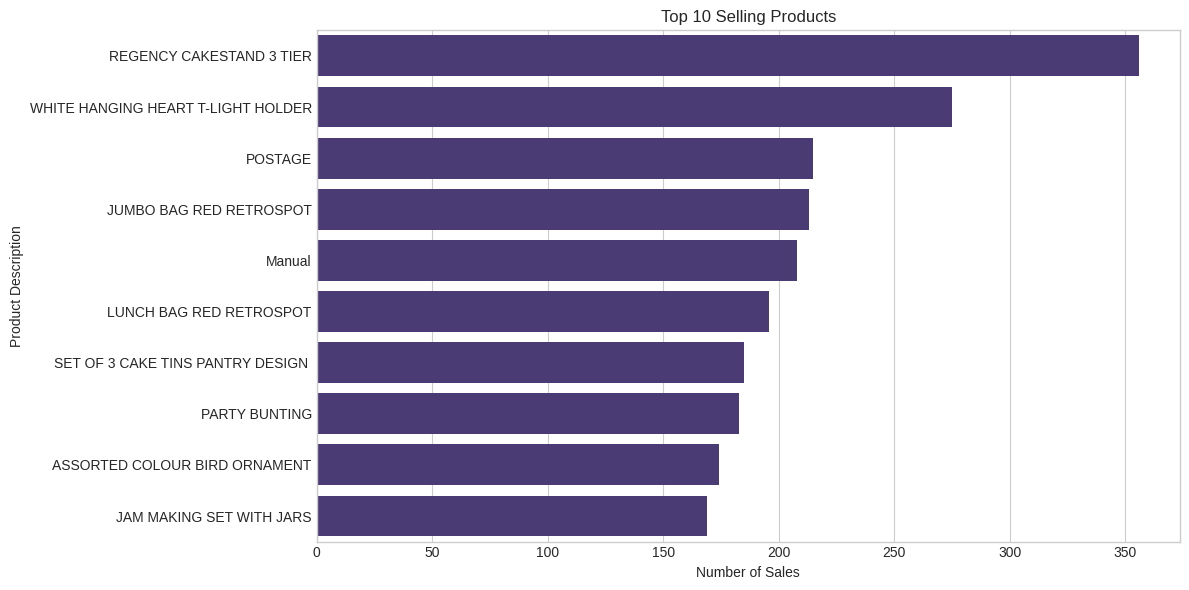

In [ ]:
# 6. Data Visualization (EDA)
# ------------------------
print("\nStarting Exploratory Data Analysis...")

# Top 10 most sold products
plt.figure(figsize=(12,6))
top_products = retail_balanced['Description'].value_counts().head(10)
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Selling Products')
plt.xlabel('Number of Sales')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

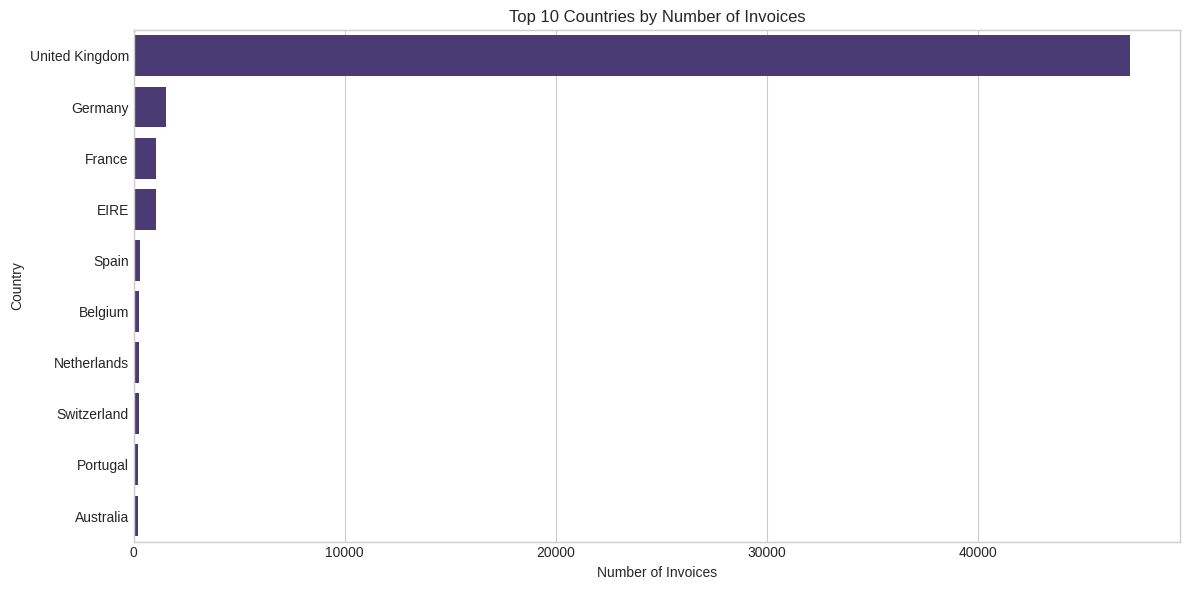

In [ ]:
# Sales by Country
plt.figure(figsize=(12,6))
country_sales = retail_balanced['Country'].value_counts().head(10)
sns.barplot(x=country_sales.values, y=country_sales.index)
plt.title('Top 10 Countries by Number of Invoices')
plt.xlabel('Number of Invoices')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

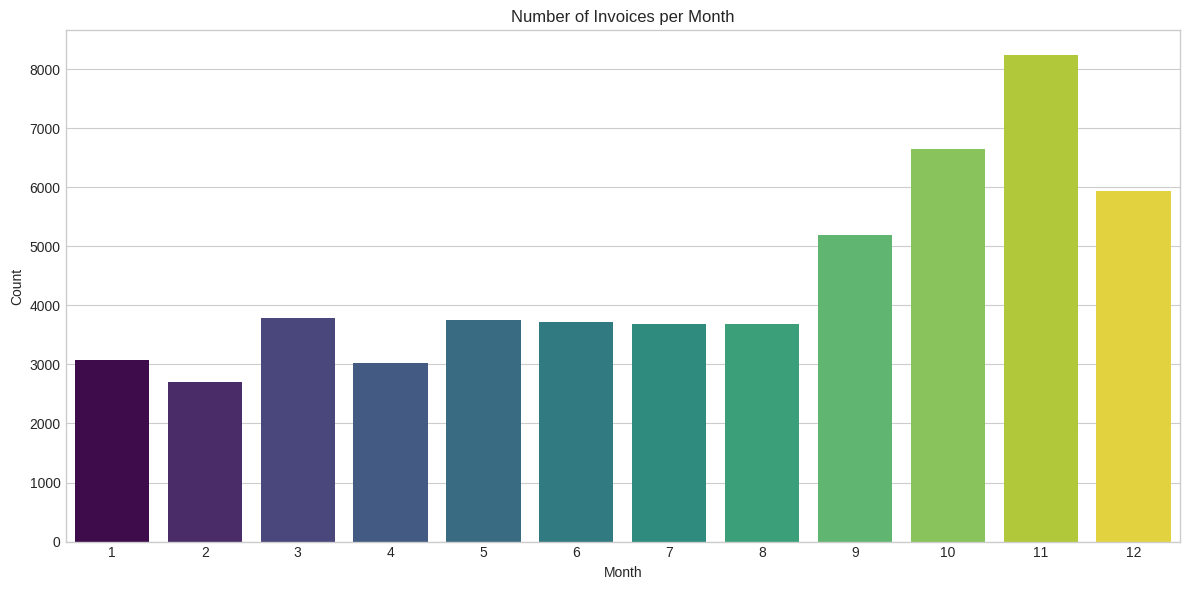

In [ ]:
# Invoices per month
plt.figure(figsize=(12,6))
sns.countplot(x='Month', data=retail_balanced, hue='Month', palette='viridis', legend=False)
plt.title('Number of Invoices per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

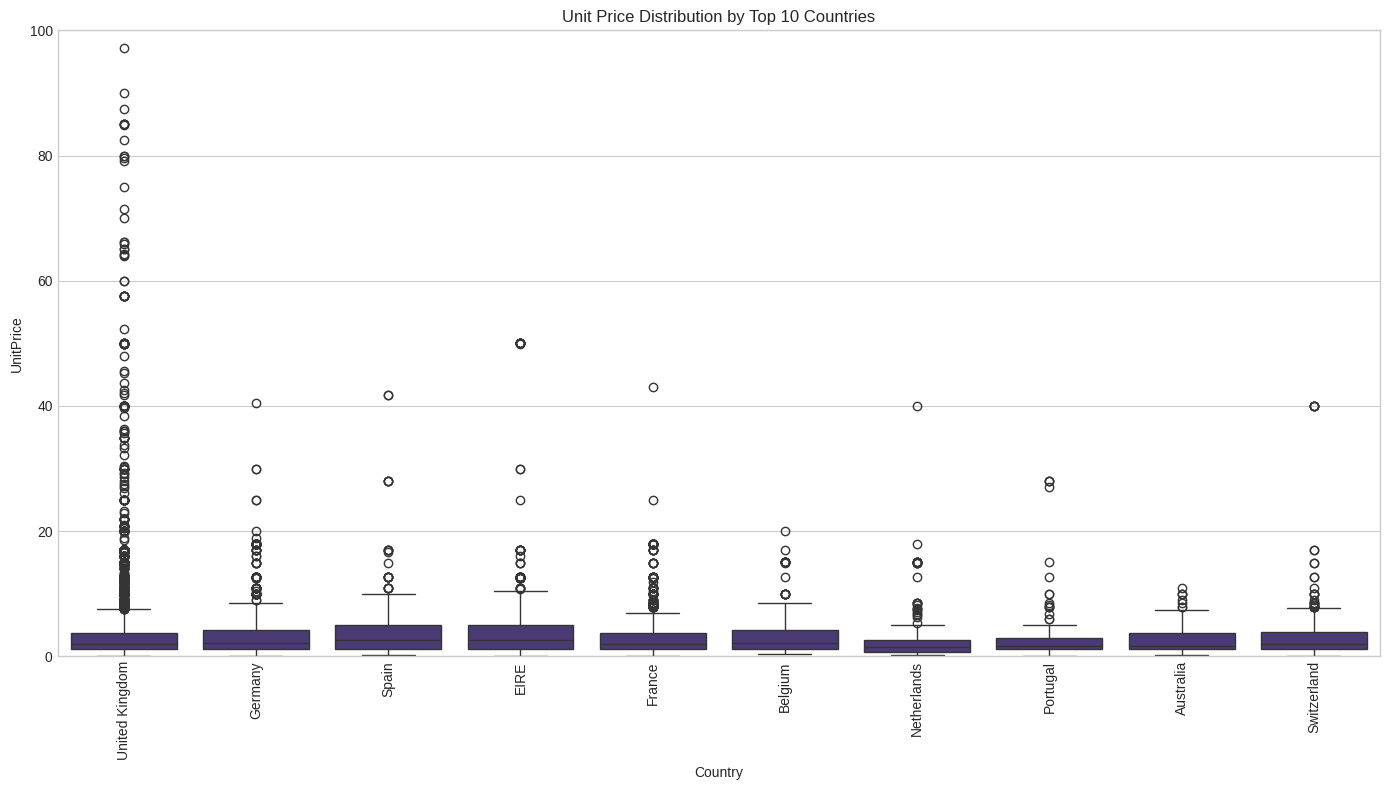

In [ ]:
# Compare UnitPrice by Country
plt.figure(figsize=(14,8))
sns.boxplot(x='Country', y='UnitPrice', data=retail_balanced[retail_balanced['Country'].isin(country_sales.index[:10])])
plt.xticks(rotation=90)
plt.title("Unit Price Distribution by Top 10 Countries")
plt.ylim(0, 100)  # Focus on reasonable prices
plt.tight_layout()
plt.show()

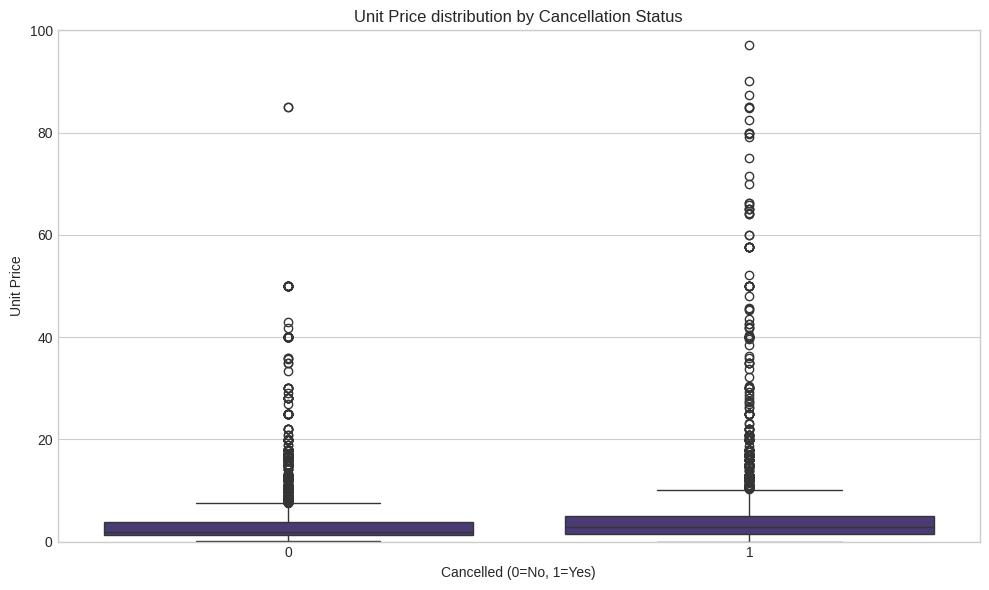

In [ ]:
# Boxplot of UnitPrice vs Cancelled
plt.figure(figsize=(10,6))
sns.boxplot(x='Cancelled', y='UnitPrice', data=retail_balanced)
plt.title('Unit Price distribution by Cancellation Status')
plt.xlabel('Cancelled (0=No, 1=Yes)')
plt.ylabel('Unit Price')
plt.ylim(0, 100)  # Focus on reasonable prices
plt.tight_layout()
plt.show()

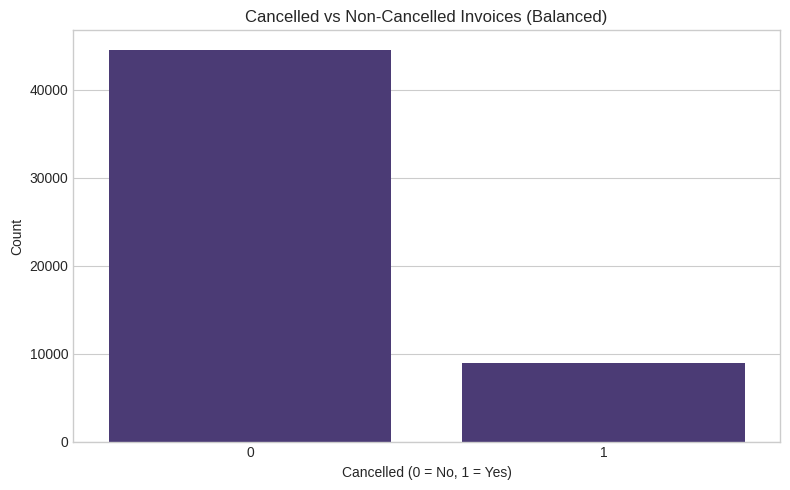

In [ ]:
# Cancelled vs Non-Cancelled Counts
plt.figure(figsize=(8,5))
sns.countplot(x='Cancelled', data=retail_balanced)
plt.title('Cancelled vs Non-Cancelled Invoices (Balanced)')
plt.xlabel('Cancelled (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

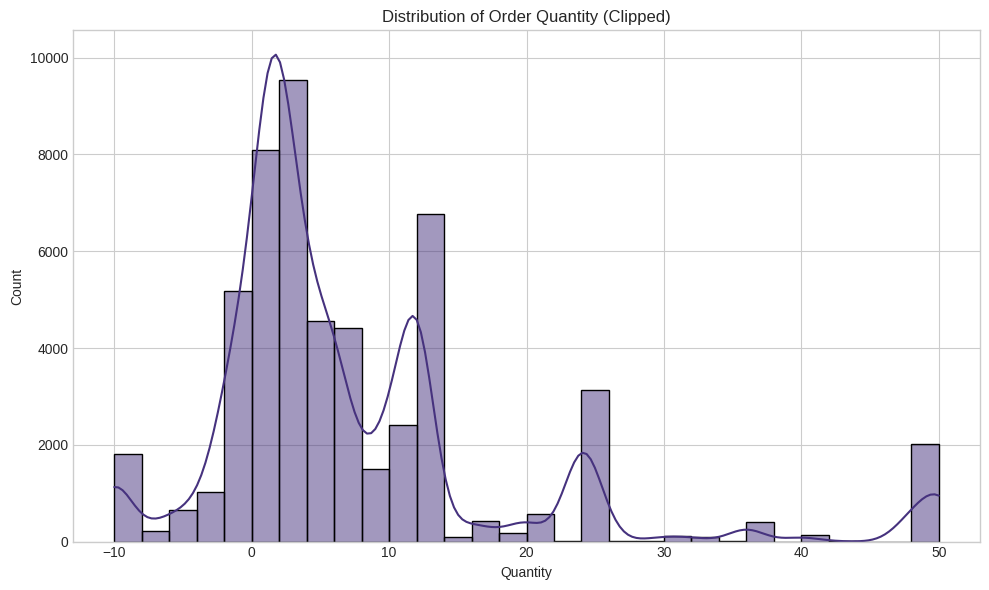

In [ ]:
# Distribution of Quantity
plt.figure(figsize=(10,6))
sns.histplot(retail_balanced['Quantity'].clip(-10, 50), bins=30, kde=True)
plt.title("Distribution of Order Quantity (Clipped)")
plt.xlabel("Quantity")
plt.tight_layout()
plt.show()

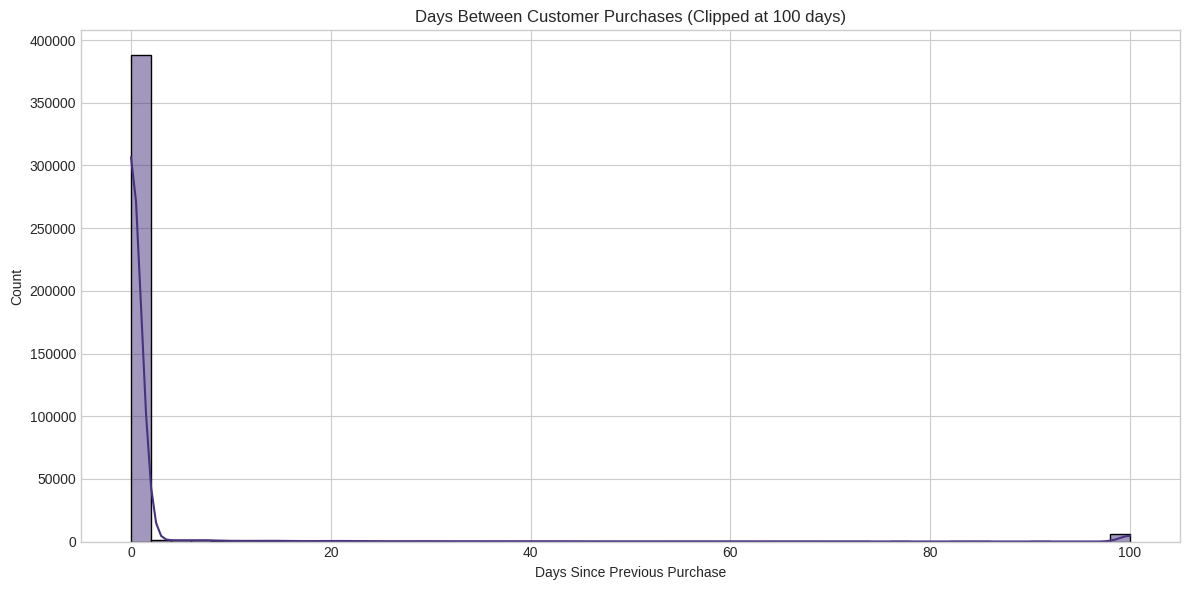

In [ ]:
# Visualize days between purchases distribution
plt.figure(figsize=(12, 6))
sns.histplot(retail_sorted['DaysSincePrevPurchase'].clip(0, 100), bins=50, kde=True)
plt.title('Days Between Customer Purchases (Clipped at 100 days)')
plt.xlabel('Days Since Previous Purchase')
plt.tight_layout()
plt.show()


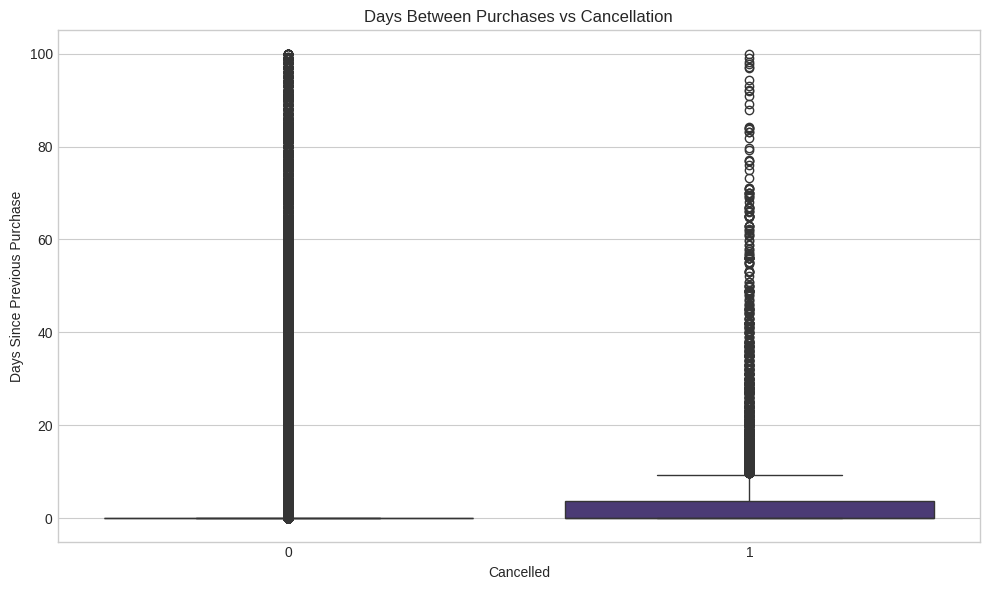

In [ ]:
# Check if time between purchases correlates with cancellation
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cancelled', y='DaysSincePrevPurchase', data=retail_sorted[retail_sorted['DaysSincePrevPurchase'] < 100])
plt.title('Days Between Purchases vs Cancellation')
plt.ylabel('Days Since Previous Purchase')
plt.tight_layout()
plt.show()


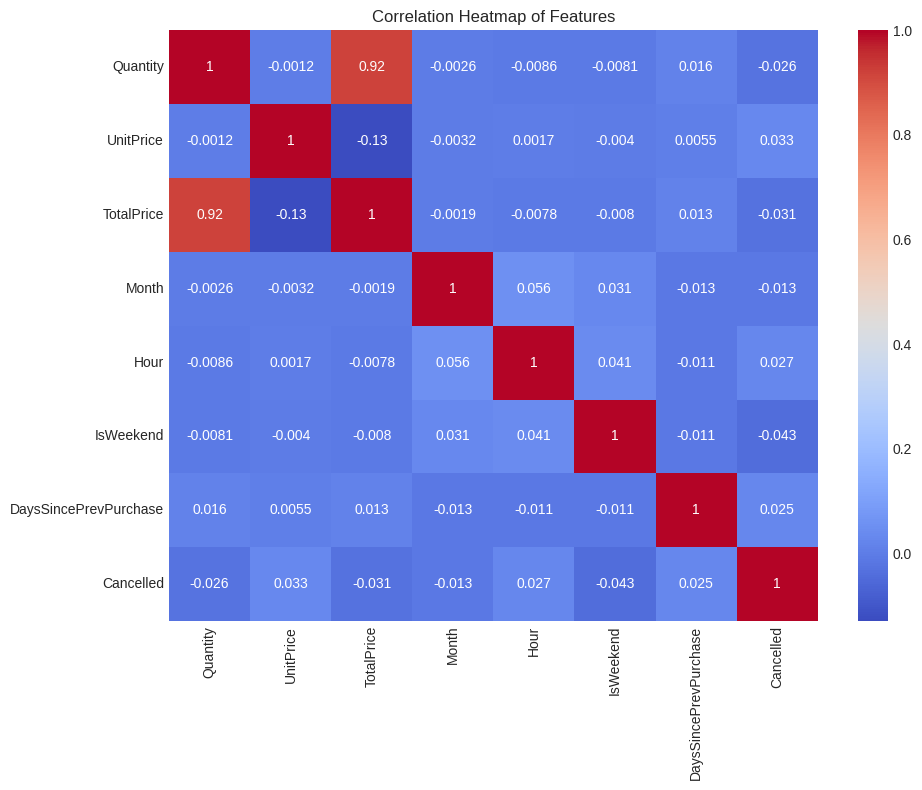

In [ ]:
# Heatmap of correlations
plt.figure(figsize=(10,8))
correlation_features = ['Quantity', 'UnitPrice', 'TotalPrice', 'Month', 'Hour',
                        'IsWeekend', 'DaysSincePrevPurchase', 'Cancelled']
sns.heatmap(retail_sorted[correlation_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()



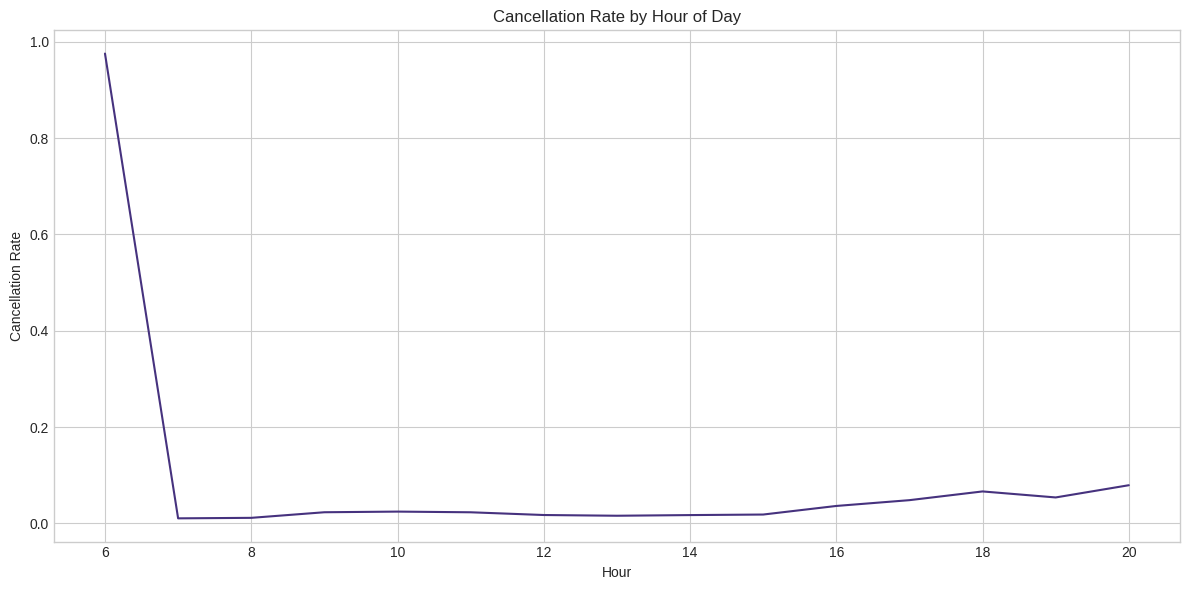

In [ ]:
  # Cancellation rate by hour of day
  plt.figure(figsize=(12,6))
  cancel_by_hour = retail.groupby('Hour')['Cancelled'].mean()
  sns.lineplot(x=cancel_by_hour.index, y=cancel_by_hour.values)
  plt.title('Cancellation Rate by Hour of Day')
  plt.xlabel('Hour')
  plt.ylabel('Cancellation Rate')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
# 7. Customer RFM Segmentation
# ------------------------
print("\nPerforming Customer RFM Segmentation...")

# Latest date in the dataset
max_date = retail_sorted['InvoiceDate'].max() + timedelta(days=1)


Performing Customer RFM Segmentation...


In [ ]:
# Create customer summary
customer_summary = retail_sorted.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                              # Frequency
    'TotalPrice': 'sum',                                 # Monetary
    'Cancelled': 'mean'                                  # Cancellation rate
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary',
    'Cancelled': 'CancellationRate'
})

In [ ]:

# View the summary
print("\nCustomer RFM Summary:")
print(customer_summary.head())
print(f"Total unique customers: {len(customer_summary)}")


Customer RFM Summary:
            Recency  Frequency  Monetary  CancellationRate
CustomerID                                                
12346.0         326          2      0.00               0.5
12347.0           2          7   4310.00               0.0
12348.0          75          4   1797.24               0.0
12349.0          19          1   1757.55               0.0
12350.0         310          1    334.40               0.0
Total unique customers: 4371


In [ ]:
# Scale RFM features for clustering
rfm_features = ['Recency', 'Frequency', 'Monetary']
scaler_rfm = StandardScaler()
customer_summary_scaled = customer_summary.copy()
customer_summary_scaled[rfm_features] = scaler_rfm.fit_transform(customer_summary[rfm_features])

In [ ]:
# Apply K-Means clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_summary['Cluster'] = kmeans.fit_predict(customer_summary_scaled[rfm_features])


In [ ]:
# Analyze clusters
cluster_analysis = customer_summary.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CancellationRate': 'mean'
})

print("\nCluster Analysis:")
print(cluster_analysis)


Cluster Analysis:
            Recency  Frequency       Monetary  CancellationRate
Cluster                                                        
0          9.181818  40.663636   18441.961455          0.046370
1        247.951242   1.805888     453.488888          0.054298
2          7.666667  88.833333  182181.981667          0.029865
3         41.615215   4.803346    1478.982242          0.023933


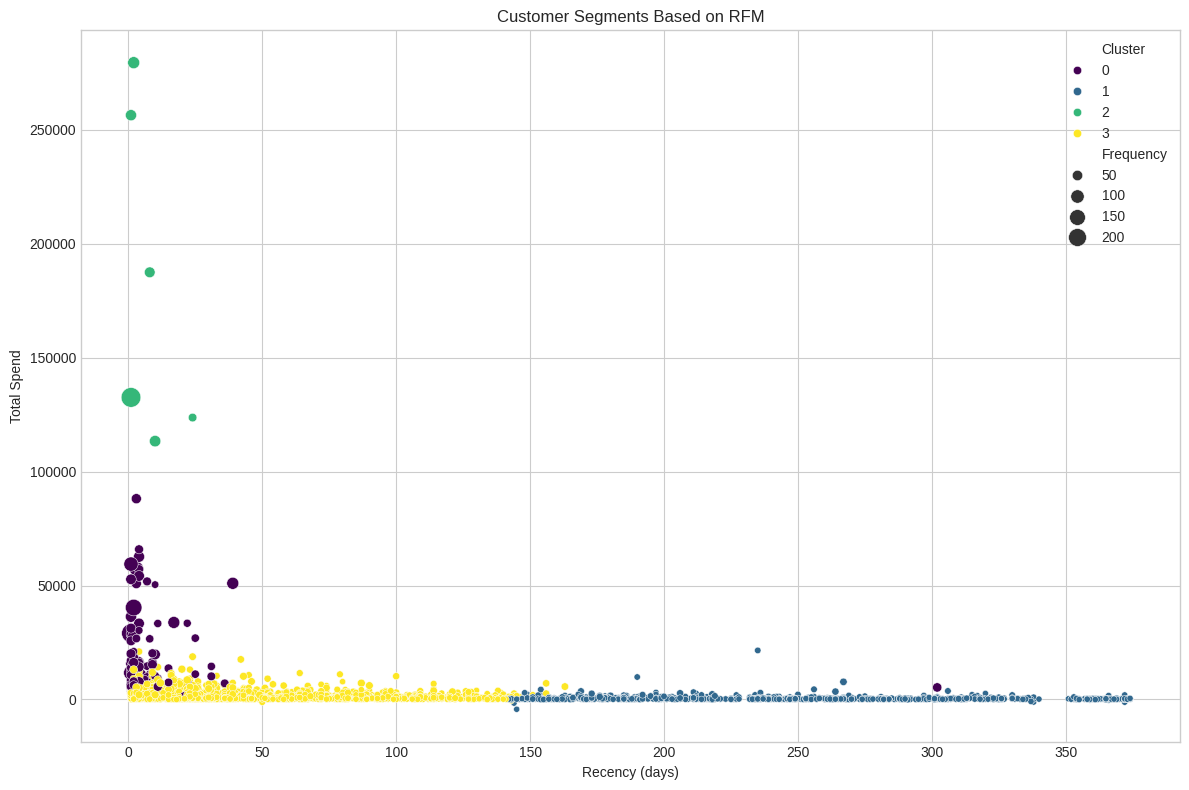

In [ ]:
# Visualize clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Recency',
    y='Monetary',
    size='Frequency',
    hue='Cluster',
    sizes=(20, 200),
    data=customer_summary,
    palette='viridis'
)
plt.title('Customer Segments Based on RFM')
plt.xlabel('Recency (days)')
plt.ylabel('Total Spend')
plt.tight_layout()
plt.show()

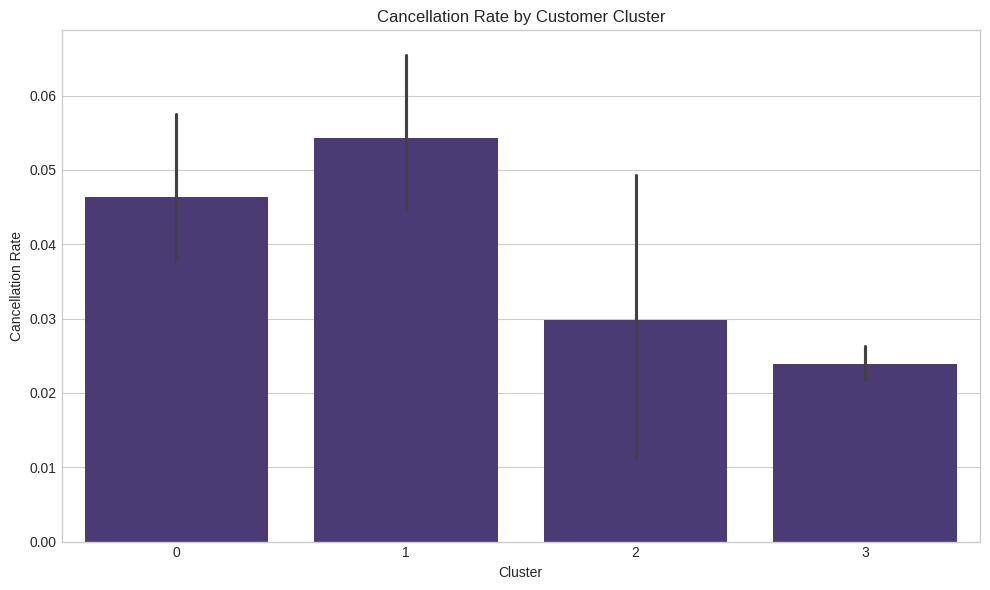

In [ ]:
# Visualize cancellation rate by cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='CancellationRate', data=customer_summary)
plt.title('Cancellation Rate by Customer Cluster')
plt.ylabel('Cancellation Rate')
plt.tight_layout()
plt.show()

In [ ]:
# Add cluster information to original data for modeling
customer_clusters = customer_summary[['Cluster']].reset_index()
retail_with_clusters = retail_sorted.merge(customer_clusters, on='CustomerID')

In [ ]:
# Add one-hot encoded cluster
cluster_dummies = pd.get_dummies(retail_with_clusters['Cluster'], prefix='Cluster')
retail_with_clusters = pd.concat([retail_with_clusters, cluster_dummies], axis=1)

In [ ]:
# 8. Prepare Data for Modeling
# ------------------------
print("\nPreparing data for modeling...")

# Define all features for modeling
basic_features = ['Quantity', 'UnitPrice', 'TotalPrice', 'Month', 'Hour']
time_features = ['DayOfWeek', 'IsWeekend', 'DaysSincePrevPurchase', 'DayOfMonth', 'Quarter']
cluster_features = [f'Cluster_{i}' for i in range(k)]


Preparing data for modeling...


In [ ]:
# Combine feature sets (you can choose which to use)
all_features = basic_features + time_features + cluster_features
print(f"Using {len(all_features)} features for modeling:")
print(", ".join(all_features))

Using 14 features for modeling:
Quantity, UnitPrice, TotalPrice, Month, Hour, DayOfWeek, IsWeekend, DaysSincePrevPurchase, DayOfMonth, Quarter, Cluster_0, Cluster_1, Cluster_2, Cluster_3


In [ ]:
# Select features from the dataframe
X = retail_with_clusters[all_features]
y = retail_with_clusters['Cancelled']

# Standardize feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split data (Train-test split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 284752 samples
Test set: 122037 samples


In [ ]:
# 9. Modeling
# ------------------------
print("\nTraining machine learning models...")

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)




Training machine learning models...


In [ ]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)



In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)



In [ ]:
# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)


In [ ]:
# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
# 10. Evaluation
# ------------------------
print("\nEvaluating model performance...")

# Function to evaluate and print metrics
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name}:")
    print(classification_report(y_true, y_pred))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# Evaluate all models
evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("Gradient Boosting", y_test, y_pred_gb)
evaluate_model("XGBoost", y_test, y_pred_xgb)



Evaluating model performance...

Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    119365
           1       1.00      0.48      0.65      2672

    accuracy                           0.99    122037
   macro avg       0.99      0.74      0.82    122037
weighted avg       0.99      0.99      0.99    122037

Accuracy: 0.9887

Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    119365
           1       1.00      1.00      1.00      2672

    accuracy                           1.00    122037
   macro avg       1.00      1.00      1.00    122037
weighted avg       1.00      1.00      1.00    122037

Accuracy: 1.0000

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    119365
           1       1.00      1.00      1.00      2672

    accuracy                           1.00    122037
   macr

<Figure size 800x600 with 0 Axes>

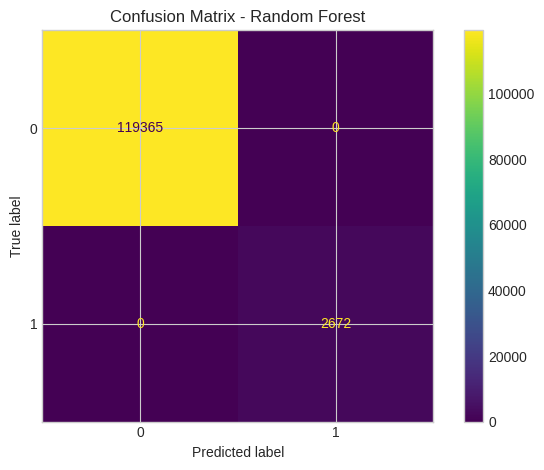

In [ ]:
# Plot confusion matrix for best model (assuming Random Forest is best)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

In [ ]:
# 11. Hyperparameter Tuning (for Random Forest)
# ------------------------
print("\nPerforming hyperparameter tuning for Random Forest...")

# Random Forest hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

gs = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=2,
    scoring='f1',
    n_jobs=-1
)

gs.fit(X_train, y_train)




Performing hyperparameter tuning for Random Forest...


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [ ]:
# Best model
print("Best parameters found:", gs.best_params_)

best_rf = gs.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("\nTuned Random Forest:")
print(classification_report(y_test, y_pred_best_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")

Best parameters found: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}

Tuned Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    119365
           1       1.00      1.00      1.00      2672

    accuracy                           1.00    122037
   macro avg       1.00      1.00      1.00    122037
weighted avg       1.00      1.00      1.00    122037

Accuracy: 1.0000


In [ ]:
# 12. Time-based Model Comparison
# ------------------------
print("\nEvaluating models across time periods...")

# Function to evaluate models by time period
def evaluate_models_by_time(data, features, target, time_col, models):
    time_periods = sorted(data[time_col].unique())
    results = []

    # Use first 70% as training data
    train_periods = time_periods[:int(len(time_periods) * 0.7)]
    train_data = data[data[time_col].isin(train_periods)]

    X_train = train_data[features]
    y_train = train_data[target]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Train models
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train_scaled, y_train)

    # Evaluate on each remaining time period
    for period in time_periods[int(len(time_periods) * 0.7):]:
        test_data = data[data[time_col] == period]
        if len(test_data) == 0:
            continue

        X_test = test_data[features]
        y_test = test_data[target]

        # Scale test data using the same scaler
        X_test_scaled = scaler.transform(X_test)

        for name, model in models.items():
            y_pred = model.predict(X_test_scaled)

            results.append({
                'Model': name,
                'Period': period,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, zero_division=0),
                'Recall': recall_score(y_test, y_pred, zero_division=0),
                'F1': f1_score(y_test, y_pred, zero_division=0)
            })

    return pd.DataFrame(results)





Evaluating models across time periods...


In [ ]:
# Define models to compare
models = {
    'Random Forest': best_rf,
    'Gradient Boosting': gb,
    'XGBoost': xgb_model,
    'Logistic Regression': lr
}

# Evaluate models over time
time_results = evaluate_models_by_time(
    retail_with_clusters,
    all_features,
    'Cancelled',
    'YearMonth',
    models
)

# Display average metrics by model
print("\nAverage metrics by model:")
print(time_results.groupby('Model')[['Accuracy', 'Precision', 'Recall', 'F1']].mean())



Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
Training Logistic Regression...

Average metrics by model:
                     Accuracy  Precision    Recall        F1
Model                                                       
Gradient Boosting    1.000000        1.0  1.000000  1.000000
Logistic Regression  0.992194        1.0  0.597573  0.747262
Random Forest        1.000000        1.0  1.000000  1.000000
XGBoost              1.000000        1.0  1.000000  1.000000


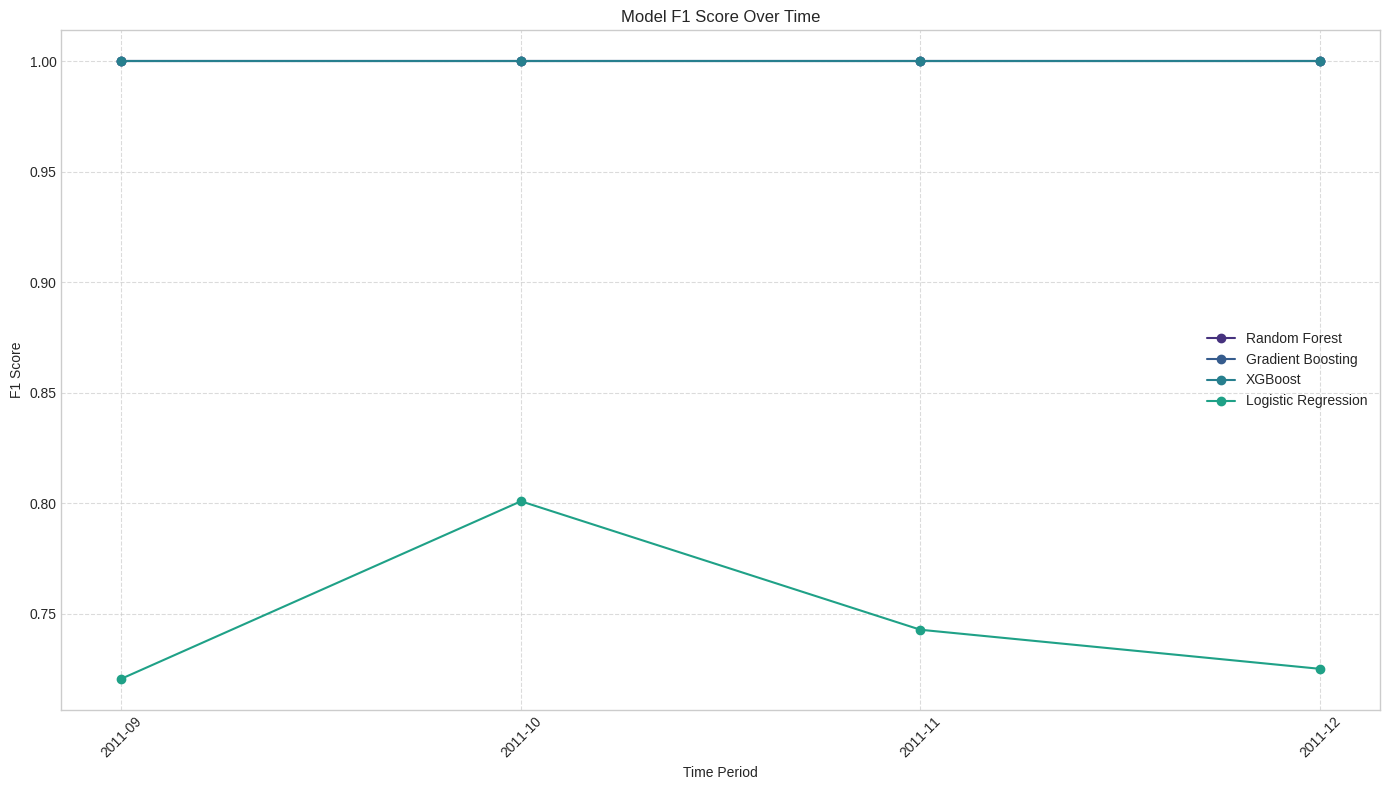

In [ ]:
# Visualize model performance over time
plt.figure(figsize=(14, 8))
for model in models.keys():
    model_data = time_results[time_results['Model'] == model]
    plt.plot(model_data['Period'].astype(str), model_data['F1'], marker='o', label=model)

plt.title('Model F1 Score Over Time')
plt.xlabel('Time Period')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Analyzing feature importance...

Top 15 features by importance:
                  Feature  Importance
0                Quantity    0.511714
2              TotalPrice    0.456551
7   DaysSincePrevPurchase    0.025592
4                    Hour    0.002509
1               UnitPrice    0.002076
5               DayOfWeek    0.000453
13              Cluster_3    0.000299
6               IsWeekend    0.000285
10              Cluster_0    0.000271
8              DayOfMonth    0.000113
9                 Quarter    0.000064
3                   Month    0.000054
11              Cluster_1    0.000015
12              Cluster_2    0.000002


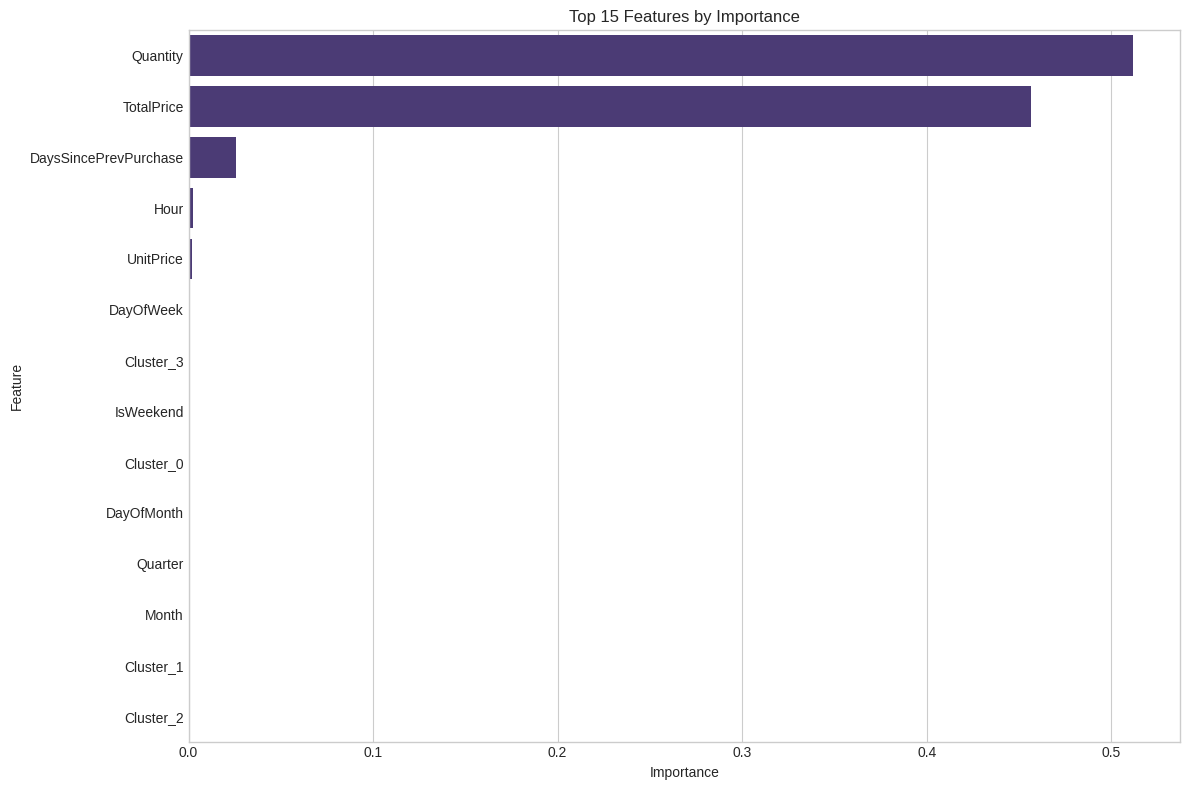

In [ ]:
# 13. Feature Importance Analysis
# ------------------------
print("\nAnalyzing feature importance...")

# Use the Random Forest model to get feature importances
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 features by importance:")
print(feature_importance.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()

In [ ]:
# 14. Recommendations Based on Analysis
# ------------------------
print("\n=== KEY INSIGHTS AND RECOMMENDATIONS ===")
print("\nCustomer Segments:")
for i in range(k):
    segment = cluster_analysis.loc[i]
    print(f"\nCluster {i}:")
    print(f"  - Recency: {segment['Recency']:.1f} days")
    print(f"  - Frequency: {segment['Frequency']:.1f} purchases")
    print(f"  - Monetary: ${segment['Monetary']:.2f}")
    print(f"  - Cancellation Rate: {segment['CancellationRate']*100:.2f}%")

    # Add segment-specific recommendations
    if segment['CancellationRate'] > 0.15:
        print("  - HIGH CANCELLATION RISK GROUP")
        if segment['Recency'] < 30:
            print("  - Recent customers with high cancellation rate - review recent product quality")
        else:
            print("  - Consider special retention offers for this segment")

    if segment['Monetary'] > 1000:
        print("  - HIGH VALUE SEGMENT - Priority service recommended")

# Identify top predictors of cancellation
print("\nTop predictors of cancellation:")
for _, row in feature_importance.head(5).iterrows():
    print(f"  - {row['Feature']}: {row['Importance']:.4f}")

# Overall recommendations
print("\nOverall Recommendations:")
print("1. Focus retention efforts on high-value customers with increased cancellation risk")
print("2. Review order process for orders placed on specific days or times with high cancellation rates")
print("3. Investigate products with above-average cancellation rates")
print("4. Consider implementing early cancellation prediction system using the best performing model")
print("5. Monitor time between purchases as a potential early warning signal")

print("\nAnalysis complete!")


=== KEY INSIGHTS AND RECOMMENDATIONS ===

Customer Segments:

Cluster 0:
  - Recency: 9.2 days
  - Frequency: 40.7 purchases
  - Monetary: $18441.96
  - Cancellation Rate: 4.64%
  - HIGH VALUE SEGMENT - Priority service recommended

Cluster 1:
  - Recency: 248.0 days
  - Frequency: 1.8 purchases
  - Monetary: $453.49
  - Cancellation Rate: 5.43%

Cluster 2:
  - Recency: 7.7 days
  - Frequency: 88.8 purchases
  - Monetary: $182181.98
  - Cancellation Rate: 2.99%
  - HIGH VALUE SEGMENT - Priority service recommended

Cluster 3:
  - Recency: 41.6 days
  - Frequency: 4.8 purchases
  - Monetary: $1478.98
  - Cancellation Rate: 2.39%
  - HIGH VALUE SEGMENT - Priority service recommended

Top predictors of cancellation:
  - Quantity: 0.5117
  - TotalPrice: 0.4566
  - DaysSincePrevPurchase: 0.0256
  - Hour: 0.0025
  - UnitPrice: 0.0021

Overall Recommendations:
1. Focus retention efforts on high-value customers with increased cancellation risk
2. Review order process for orders placed on spec